<a href="https://colab.research.google.com/github/Ranitdas26/SuperHero-Name-Generator/blob/main/Superhero_Name_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Superhero (and Supervillain) Name Generator

[Superhero Names Dataset](https://github.com/am1tyadav/superhero)

# Task 2
1. Import the data
2. Create a tokenizer
3. Char to index and Index to char dictionaries

In [30]:
!git clone https://github.com/am1tyadav/superhero

fatal: destination path 'superhero' already exists and is not an empty directory.


In [31]:
with open('superhero/superheroes.txt', 'r') as f:
  data = f.read()
data[:100]

'jumpa\t\ndoctor fate\t\nstarlight\t\nisildur\t\nlasher\t\nvarvara\t\nthe target\t\naxel\t\nbattra\t\nchangeling\t\npyrrh'

In [32]:
import tensorflow as tf
print(tf.__version__)

2.5.0


In [33]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~',
    split='\n',
)

In [34]:
tokenizer.fit_on_texts(data)

In [35]:
char_to_index = tokenizer.word_index
index_to_char = dict((v,k) for k, v in char_to_index.items())

print(index_to_char)

{1: '\t', 2: 'a', 3: 'e', 4: 'r', 5: 'o', 6: 'n', 7: 'i', 8: ' ', 9: 't', 10: 's', 11: 'l', 12: 'm', 13: 'h', 14: 'd', 15: 'c', 16: 'u', 17: 'g', 18: 'k', 19: 'b', 20: 'p', 21: 'y', 22: 'w', 23: 'f', 24: 'v', 25: 'j', 26: 'z', 27: 'x', 28: 'q'}


## Task 3

1. Converting between names and sequences

In [36]:
names = data.splitlines()
names[:10]

['jumpa\t',
 'doctor fate\t',
 'starlight\t',
 'isildur\t',
 'lasher\t',
 'varvara\t',
 'the target\t',
 'axel\t',
 'battra\t',
 'changeling\t']

In [37]:
tokenizer.texts_to_sequences(names[0])

[[25], [16], [12], [20], [2], [1]]

In [38]:
def name_to_seq(name):
  return [tokenizer.texts_to_sequences(c)[0][0] for c in name]

In [39]:
name_to_seq(names[0])

[25, 16, 12, 20, 2, 1]

In [40]:
def seq_to_name(seq):
  return ''.join([index_to_char[i] for i in seq if i!=0])

In [41]:
seq_to_name(name_to_seq(names[1]))

'doctor fate\t'

## Task 4

1. Creating sequences
2. Padding all sequences

In [42]:
sequences = []

for name in names:
  seq = name_to_seq(name)
  if len(seq)>= 2: #Creating sequences with atleast 2 characters in it
    sequences += [seq[:i] for i in range(2, len(seq) + 1)] 

In [43]:
sequences[:10]

[[25, 16],
 [25, 16, 12],
 [25, 16, 12, 20],
 [25, 16, 12, 20, 2],
 [25, 16, 12, 20, 2, 1],
 [14, 5],
 [14, 5, 15],
 [14, 5, 15, 9],
 [14, 5, 15, 9, 5],
 [14, 5, 15, 9, 5, 4]]

In [44]:
max_len = max([len(x) for x in sequences])
print(max_len)

33


In [45]:
padded_sequences = tf.keras.preprocessing.sequence.pad_sequences(
    sequences, padding='pre',
    maxlen=max_len
)
print(padded_sequences[0])

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0 25 16]


In [46]:
padded_sequences.shape

(88279, 33)

## Task 5: Creating Training and Validation Sets

1. Creating training and validation sets

In [47]:
x, y = padded_sequences[:, :-1], padded_sequences[:, -1]
print(x.shape, y.shape)

(88279, 32) (88279,)


In [48]:
from sklearn.model_selection import train_test_split

In [49]:
x_train, x_test, y_train, y_test = train_test_split(x,y)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(66209, 32) (66209,)
(22070, 32) (22070,)


In [50]:
num_chars = len(char_to_index.keys()) + 1
print(num_chars)

29


## Task 6 : Creating The Model

In [56]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPool1D, LSTM
from tensorflow.keras.layers import Bidirectional, Dense

model = Sequential([
                    Embedding(num_chars, 16, input_length=max_len-1),
                    Conv1D(64, 5, strides=1, activation='tanh', padding='causal'),
                    MaxPool1D(2),
                    LSTM(64),
                    Dense(num_chars, activation='softmax')
])

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy'],
)

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 32, 16)            464       
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 32, 64)            5184      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 16, 64)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense_4 (Dense)              (None, 29)                1885      
Total params: 40,557
Trainable params: 40,557
Non-trainable params: 0
_________________________________________________________________


## Training The Model

In [58]:
h = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=50, verbose=2
)

Epoch 1/50
2070/2070 - 13s - loss: 2.2814 - accuracy: 0.3087 - val_loss: 2.2925 - val_accuracy: 0.3048
Epoch 2/50
2070/2070 - 12s - loss: 2.2270 - accuracy: 0.3238 - val_loss: 2.2516 - val_accuracy: 0.3226
Epoch 3/50
2070/2070 - 12s - loss: 2.1784 - accuracy: 0.3384 - val_loss: 2.2246 - val_accuracy: 0.3289
Epoch 4/50
2070/2070 - 12s - loss: 2.1349 - accuracy: 0.3528 - val_loss: 2.1988 - val_accuracy: 0.3426
Epoch 5/50
2070/2070 - 12s - loss: 2.0925 - accuracy: 0.3664 - val_loss: 2.1799 - val_accuracy: 0.3524
Epoch 6/50
2070/2070 - 12s - loss: 2.0559 - accuracy: 0.3812 - val_loss: 2.1674 - val_accuracy: 0.3594
Epoch 7/50
2070/2070 - 12s - loss: 2.0223 - accuracy: 0.3904 - val_loss: 2.1516 - val_accuracy: 0.3660
Epoch 8/50
2070/2070 - 12s - loss: 1.9910 - accuracy: 0.4006 - val_loss: 2.1467 - val_accuracy: 0.3666
Epoch 9/50
2070/2070 - 12s - loss: 1.9616 - accuracy: 0.4104 - val_loss: 2.1332 - val_accuracy: 0.3706
Epoch 10/50
2070/2070 - 12s - loss: 1.9353 - accuracy: 0.4174 - val_loss:

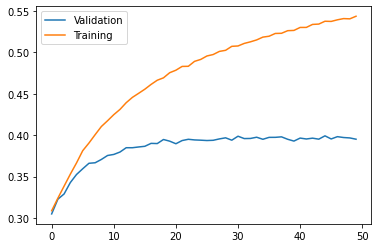

In [59]:
from matplotlib import pyplot as plt

epochs_ran = len(h.history['loss'])

plt.plot(range(0,epochs_ran), h.history['val_accuracy'], label='Validation')
plt.plot(range(0,epochs_ran), h.history['accuracy'], label='Training')
plt.legend()
plt.show()

## Generating Names

In [60]:
def generate_names(seed):
  for i in range(0,40):
    seq = name_to_seq(seed)
    padded = tf.keras.preprocessing.sequence.pad_sequences([seq], padding='pre', 
                                                           maxlen=max_len-1,
                                                           truncating='pre')
    pred = model.predict(padded)[0]
    pred_char = index_to_char[tf.argmax(pred).numpy()]
    seed += pred_char

    if pred_char == '\t':
      break
  print(seed)

In [72]:
generate_names('a')

alex latter	
